In [1]:
import pandas as pd
import numpy as np
import eia
import requests
import json
import yaml
from prophet import Prophet

# Definitions
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
pd.set_option('display.max_columns', 100)    #Display upto 100 columns 
pd.set_option('display.max_rows', 100) 
%matplotlib inline

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')   

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
# To be able to pull modules from src folder 
import os
import sys
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)

In [4]:
from d00_utils.const import *
from d00_utils.utils import setup_env_vars, load_yml, get_filepath

setup_env_vars()
os.environ.get("EIA_ACCESS_KEY")

2022-03-07 20:57:01.816 INFO    d00_utils.utils: Finding .env file to load entries as environment variables...
2022-03-07 20:57:01.820 INFO    d00_utils.utils: Finished loading environment variables.


'xPWAeqwYEwqmxA0hFnjsCUbcyxEG95ajpq4aX89p'

## Pulling Raw Data (JSON) and Creating Intermediate CSVs
So far, we've pulled all the raw data we're interested in and created intermediate CSVS for it - including handling of failed API requests. 

In [5]:
eia_api_ids = load_yml(EIA_API_IDS_YML_FILEPATH)
for data_type, api_ids_dict in eia_api_ids.items(): 
    print(data_type, api_ids_dict)
    print('\n')

Net_Gen_By_Fuel_MWh {'all_fuels': 'ELEC.GEN.ALL-{}-99.Q', 'coal': 'ELEC.GEN.COW-{}-99.Q', 'natural_gas': 'ELEC.GEN.NG-{}-99.Q', 'nuclear': 'ELEC.GEN.NUC-{}-99.Q', 'hydro': 'ELEC.GEN.HYC-{}-99.Q', 'other_renewables': 'ELEC.GEN.AOR-{}-99.Q', 'wind': 'ELEC.GEN.WND-{}-99.Q', 'solar_utility': 'ELEC.GEN.SUN-{}-99.Q', 'solar_all': 'ELEC.GEN.TSN-{}-99.Q', 'other': 'ELEC.GEN.OTH-{}-99.Q'}


Fuel_Consumption_BTU {'coal': 'ELEC.CONS_TOT_BTU.COW-{}-99.Q', 'natural_gas': 'ELEC.CONS_TOT_BTU.NG-{}-99.Q'}




In [19]:
# Working code so far
from d01_data.get_raw_data import load_all_data
from d02_intermediate.clean_raw_data import clean_all_data
from d03_processing.create_model_input import process_all_data

load_all_data(eia_api_ids)
clean_all_data(eia_api_ids)
process_all_data(eia_api_ids)

2022-03-05 11:55:45,182 - Invalid response for EIA Series ID: elec.gen.wnd-al-99.q with error message: invalid series_id. For key registration, documentation, and examples see https://www.eia.gov/developer/
2022-03-05 11:55:45,304 - Invalid response for EIA Series ID: elec.gen.wnd-ar-99.q with error message: invalid series_id. For key registration, documentation, and examples see https://www.eia.gov/developer/


## Model Training and Forecasting
With all the data cleaned, imputed and engineered to create the processed data which will be fed into the ML models for training, the next step is to create a framework for training and saving the time-series models for each dataset. 

In [62]:
# Sample intermediate files for testing: 
all_fuels = '../data/03_processed/Net_Gen_By_Fuel_MWh/AL/Net_Gen_By_Fuel_MWh-all_fuels.csv'
coal = '../data/03_processed/Net_Gen_By_Fuel_MWh/AL/Net_Gen_By_Fuel_MWh-coal.csv'

df_all_fuels = pd.read_csv(all_fuels)
df_coal = pd.read_csv(coal)
df_all_fuels.head()

,ds,y
0,2001-03-31,30267.126
1,2001-06-30,28933.315
2,2001-09-30,35618.737
3,2001-12-31,30525.935
4,2002-03-31,30347.665


In [63]:
df_coal.columns = ['ds', 'y']
# df_coal['cap'] = df_coal.y.max()
# df_coal['floor'] = 0
df_coal.head()

,ds,y
0,2001-03-31,17430.289
1,2001-06-30,17043.527
2,2001-09-30,20808.621
3,2001-12-31,16915.677
4,2002-03-31,14804.407


In [64]:
# m = Prophet(growth='logistic')
m = Prophet()
m.fit(df_coal)

2022-03-05 18:03:50,802 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-03-05 18:03:50,803 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -92.1797
Iteration  1. Log joint probability =    68.6238. Improved by 160.803.
Iteration  2. Log joint probability =    127.623. Improved by 58.9992.
Iteration  3. Log joint probability =    127.625. Improved by 0.00178294.
Iteration  4. Log joint probability =    127.662. Improved by 0.0367992.
Iteration  5. Log joint probability =    127.704. Improved by 0.0421381.
Iteration  6. Log joint probability =    155.338. Improved by 27.6338.
Iteration  7. Log joint probability =    155.422. Improved by 0.0843067.
Iteration  8. Log joint probability =    155.726. Improved by 0.303883.
Iteration  9. Log joint probability =    155.848. Improved by 0.122752.
Iteration 10. Log joint probability =    155.965. Improved by 0.116853.
Iteration 11. Log joint probability =    156.014. Improved by 0.0488764.
Iteration 12. Log joint probability =     156.02. Improved by 0.00598548.
Iteration 13. Log joint probability =    156.117. Improved by 0.0971122.
Iteration 14. Lo

 joint probability =    156.247. Improved by 0.129757.
Iteration 15. Log joint probability =    156.341. Improved by 0.0942676.
Iteration 16. Log joint probability =    156.386. Improved by 0.0442238.
Iteration 17. Log joint probability =    157.226. Improved by 0.840682.
Iteration 18. Log joint probability =    157.612. Improved by 0.386101.
Iteration 19. Log joint probability =    157.972. Improved by 0.359359.
Iteration 20. Log joint probability =    158.016. Improved by 0.0447275.
Iteration 21. Log joint probability =    158.067. Improved by 0.0504137.
Iteration 22. Log joint probability =    158.121. Improved by 0.0538752.
Iteration 23. Log joint probability =    158.295. Improved by 0.174192.
Iteration 24. Log joint probability =    158.988. Improved by 0.692927.
Iteration 25. Log joint probability =    159.053. Improved by 0.0647175.
Iteration 26. Log joint probability =    159.226. Improved by 0.173366.
Iteration 27. Log joint probability =    159.885. Improved by 0.658817.
Ite

In [65]:
future = m.make_future_dataframe(periods=24, freq='Q')
future.tail()

,ds
103,2026-12-31
104,2027-03-31
105,2027-06-30
106,2027-09-30
107,2027-12-31


In [66]:
# future['cap'] = df_coal.y.max()
# future['floor'] = 0
forecast = m.predict(future)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
103,2026-12-31,-13560.142,-2339.195,1160.692,-13865.605,-13217.570,13024.839,13024.839,13024.839,13024.839,13024.839,13024.839,0.000,0.000,0.000,-535.303
104,2027-03-31,-13784.996,-2229.577,1437.883,-14113.374,-13416.096,13337.385,13337.385,13337.385,13337.385,13337.385,13337.385,0.000,0.000,0.000,-447.611
105,2027-06-30,-14012.349,-1789.091,1768.944,-14366.370,-13610.613,13996.935,13996.935,13996.935,13996.935,13996.935,13996.935,0.000,0.000,0.000,-15.414
106,2027-09-30,-14242.199,217.315,3609.307,-14622.984,-13810.806,16082.126,16082.126,16082.126,16082.126,16082.126,16082.126,0.000,0.000,0.000,1839.926
107,2027-12-31,-14472.050,-3337.899,154.226,-14881.528,-14014.625,12843.684,12843.684,12843.684,12843.684,12843.684,12843.684,0.000,0.000,0.000,-1628.366


In [19]:
forecast['y'] = m.history['y'].combine_first(forecast['yhat'])
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
0,2001-03-31,5644.495,16425.991,19728.290,5644.495,5644.495,12440.017,12440.017,12440.017,12440.017,12440.017,12440.017,0.000,0.000,0.000,18084.512,17430.289
1,2001-06-30,5595.720,16703.295,20141.191,5595.720,5595.720,12959.626,12959.626,12959.626,12959.626,12959.626,12959.626,0.000,0.000,0.000,18555.346,17043.527
2,2001-09-30,5546.410,19261.031,22920.267,5546.410,5546.410,15554.214,15554.214,15554.214,15554.214,15554.214,15554.214,0.000,0.000,0.000,21100.623,20808.621
3,2001-12-31,5497.099,17177.807,20470.923,5497.099,5497.099,13230.402,13230.402,13230.402,13230.402,13230.402,13230.402,0.000,0.000,0.000,18727.501,16915.677
4,2002-03-31,5448.860,16596.893,20229.821,5448.860,5448.860,12972.509,12972.509,12972.509,12972.509,12972.509,12972.509,0.000,0.000,0.000,18421.369,14804.407


In [ ]:
# Test function after adding to script 
from d04_modelling.create_prophet_models import train_all_models
train_all_models(eia_api_ids)

from d06_reporting.create_forecasts import create_all_forecasts
create_all_forecasts(eia_api_ids)

# Plotting Forecasts 

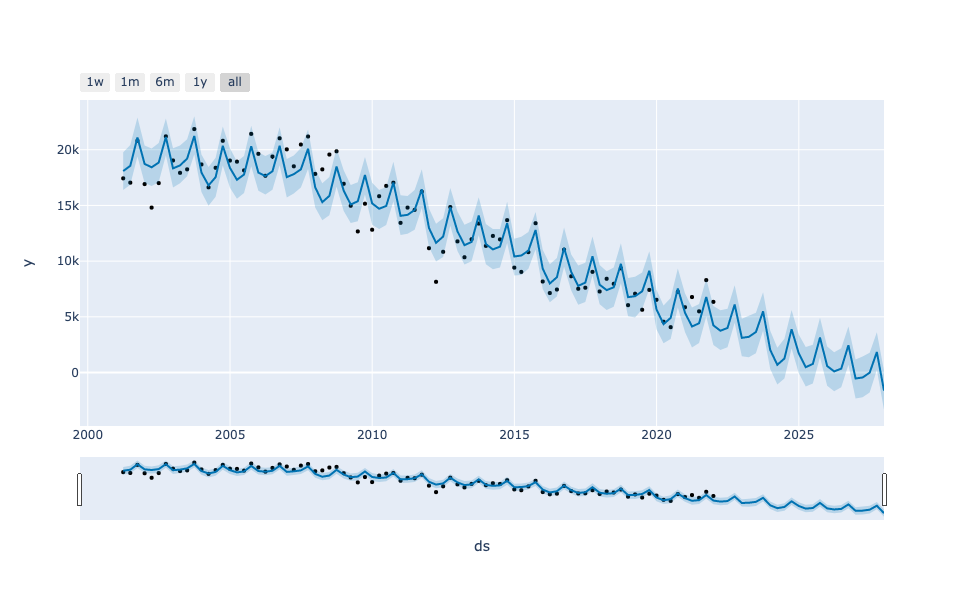

In [69]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)
# fig1 = m.plot(forecast, plot_cap=True, uncertainty=True)

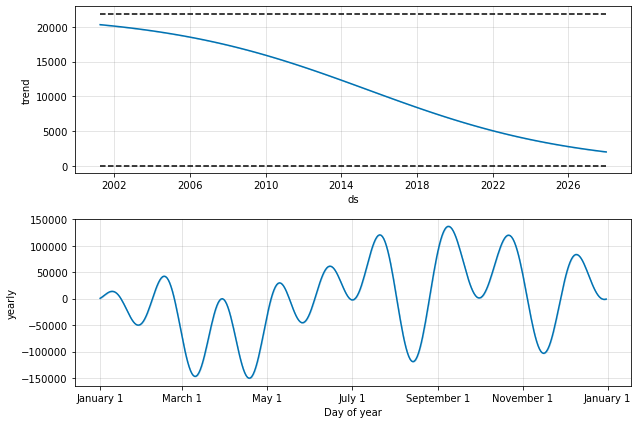

In [56]:
fig2 = m.plot_components(forecast)
# plot_components_plotly(m, forecast)

# Testing Forecast 

In [6]:
# Sample intermediate files for testing: 

forecast_path = '../data/06_reporting/Individual_Forecasts/Net_Gen_By_Fuel_MWh/AL/Net_Gen_By_Fuel_MWh-all_fuels.csv'

df = pd.read_csv(forecast_path)
df.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
0,2001-03-31,74592.088,29222.832,32153.771,74592.088,74592.088,-43926.543,-43926.543,-43926.543,-43926.543,-43926.543,-43926.543,0.000,0.000,0.000,30665.545,30267.126
1,2001-06-30,74733.675,29155.860,32151.105,74733.675,74733.675,-44053.643,-44053.643,-44053.643,-44053.643,-44053.643,-44053.643,0.000,0.000,0.000,30680.032,28933.315
2,2001-09-30,74876.818,34617.976,37586.587,74876.818,74876.818,-38787.884,-38787.884,-38787.884,-38787.884,-38787.884,-38787.884,0.000,0.000,0.000,36088.934,35618.737
3,2001-12-31,75019.960,29573.448,32607.057,75019.960,75019.960,-43833.667,-43833.667,-43833.667,-43833.667,-43833.667,-43833.667,0.000,0.000,0.000,31186.293,30525.935
4,2002-03-31,75159.991,29993.321,32885.580,75159.991,75159.991,-43760.181,-43760.181,-43760.181,-43760.181,-43760.181,-43760.181,0.000,0.000,0.000,31399.810,30347.665


In [10]:
today = pd.to_datetime('today')
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')
df_hist = df[df['ds'] < today]
df_hist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 0 to 83
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          84 non-null     datetime64[ns]
 1   trend                       84 non-null     float64       
 2   yhat_lower                  84 non-null     float64       
 3   yhat_upper                  84 non-null     float64       
 4   trend_lower                 84 non-null     float64       
 5   trend_upper                 84 non-null     float64       
 6   additive_terms              84 non-null     float64       
 7   additive_terms_lower        84 non-null     float64       
 8   additive_terms_upper        84 non-null     float64       
 9   yearly                      84 non-null     float64       
 10  yearly_lower                84 non-null     float64       
 11  yearly_upper                84 non-null     float64       
 

In [14]:
pd.to_datetime('today') + pd.tseries.offsets.QuarterEnd()

Timestamp('2022-03-31 19:34:06.552202')

# Emissions Calculation

In [9]:
emission_factors = load_yml(EMISSIONS_FACTORS_YML_FILEPATH)
emission_factors
for data_type, emissions_dict in emission_factors.items(): 
    print(data_type, emissions_dict)
    print('\n')

Net_Gen_By_Fuel_MWh {'coal': 10, 'natural_gas': 71, 'nuclear': 13, 'hydro': 21, 'other_renewables': 31, 'wind': 13, 'solar_utility': 43, 'solar_all': 43, 'other': 31}


Fuel_Consumption_BTU {'coal': 96.252, 'natural_gas': 53.1145}




In [6]:
forecast_path = '../data/06_reporting/Combined_Forecasts/AL/Net_Gen_By_Fuel_MWh-Combined.csv'

df = pd.read_csv(forecast_path)
df.head()

,date,all_fuels,coal,natural_gas,nuclear,hydro,wind,solar_all,other
0,2001-03-31,30267.126,17430.289,1232.544,7329.546,2948.996,0.000,0.000,1090.582
1,2001-06-30,28933.315,17043.527,2054.004,6862.282,1787.000,0.000,0.000,1007.158
2,2001-09-30,35618.737,20808.621,3374.592,8543.381,1725.684,0.000,0.000,1060.303
3,2001-12-31,30525.935,16915.677,2951.542,7621.854,1894.702,0.000,0.000,1039.133
4,2002-03-31,30347.665,14804.407,3534.879,8301.900,2509.305,0.000,0.000,1048.004


In [16]:
df_emissions = pd.DataFrame()
df_emissions["date"] = df["date"]

net_gen_fuels = ['coal', 'natural_gas', 'nuclear',
                     'hydro', 'wind', 'solar_all', 'other']
for fuel in net_gen_fuels: 
    df_emissions[fuel] = 0 

for data_type, emissions_dict in emission_factors.items(): 
    for col in df.columns:
        if col in emissions_dict:
            print(col, emissions_dict[col])
            df_emissions[col] += emissions_dict[col] * df[col]      
df_emissions["all_fuels"] = df_emissions.iloc[:, 1:].sum(axis=1)
df_emissions

coal 10
natural_gas 71
nuclear 13
hydro 21
wind 13
solar_all 43
other 31
coal 96.252
natural_gas 53.1145


,date,coal,natural_gas,nuclear,hydro,wind,solar_all,other,all_fuels
0,2001-03-31,1852003.067,152976.582,95284.098,61928.916,0.000,0.000,33808.042,2196000.705
1,2001-06-30,1810908.831,254931.679,89209.666,37527.000,0.000,0.000,31221.898,2223799.075
2,2001-09-30,2210957.598,418835.799,111063.953,36239.364,0.000,0.000,32869.393,2809966.108
3,2001-12-31,1797324.513,366329.160,99084.102,39788.742,0.000,0.000,32213.123,2334739.639
4,2002-03-31,1572997.853,438729.740,107924.700,52695.405,0.000,0.000,32488.124,2204835.821
5,2002-06-30,1806795.816,465802.091,103578.241,35660.604,0.000,0.000,29539.032,2441375.784
6,2002-09-30,2252262.213,746392.706,103723.906,25348.554,0.000,0.000,33896.268,3161623.647
7,2002-12-31,2022515.214,323000.539,98913.191,71615.964,0.000,0.000,24004.416,2540049.324
8,2003-03-31,1904760.160,324745.093,95065.516,74578.161,0.000,0.000,28650.138,2427799.068
9,2003-06-30,1937773.400,332501.753,97873.776,78166.263,0.000,0.000,27106.555,2473421.747
